In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import matplotlib.pyplot as plt

# SCRAPE OBSERVATION DATA

In [4]:
import csv
import time

from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import pickle
import requests


def scrape_data_one_day(station_id, year, month, day):
    """
    Retrieve PWS data for given station and a given day
    :param station_id: string
        PWS station ID
    :param year: int
        year
    :param month: int
        month
    :param day: int
        day
    :return: pandas DataFrame with data for requested day

    Sample URL:
    https://www.wunderground.com/weatherstation/WXDailyHistory.asp?
    ID=KWAEDMON15&day=18&month=4&year=2017&graphspan=day&format=1

    """

    url = "https://www.wunderground.com/" \
          "weatherstation/WXDailyHistory.asp?ID=" \
          + station_id + "&day=" \
          + str(day) + "&month=" \
          + str(month) + "&year=" \
          + str(year) \
          + "&graphspan=day&format=1"

    content = requests.get(url).text
    content = content.replace("\n", "")
    content = content.replace("<br>", "\n")
    content = content.replace(",\n", "\n")

    data_csv_lines = csv.reader(content.split('\n'), delimiter=',')
    data_list = list(data_csv_lines)
    data_df = pd.DataFrame.from_records(data_list[1:-1], columns=data_list[0])

    return data_df


def scrape_data_multi_day(station_id, start_date, end_date,
                          delay=3, combined_df=None):
    """
    Retrieve PWS data for given station and a given date range
    :param station_id: string
        PWS station ID
    :param startdate: int (yyyymmdd)
        start date for data retrieval
    :param enddate: int (yyyymmdd)
        end date for data retrieval
    :param delay: int
        delay between requests to WU server (seconds)
    :return: pandas DataFrame with combined data for period requested
    """

    if combined_df is None:
        combined_df = pd.DataFrame()
    else:
        pass

    # parse out date components
    start_date_str = str(start_date)
    start_date_yyyy = int(start_date_str[0:4])
    start_date_mm = int(start_date_str[4:6])
    start_date_dd = int(start_date_str[6:8])
    end_date_str = str(end_date)
    end_date_yyyy = int(end_date_str[0:4])
    end_date_mm = int(end_date_str[4:6])
    end_date_dd = int(end_date_str[6:8])

    # create date range
    start_date_pd = pd.datetime(start_date_yyyy, start_date_mm, start_date_dd)
    end_date_pd = pd.datetime(end_date_yyyy, end_date_mm, end_date_dd)
    date_list = pd.date_range(start_date_pd, end_date_pd)

    for date in date_list:
        temp_yyyy = date.year
        temp_mm = date.month
        temp_dd = date.day
        print('retrieving data for ' + station_id + " on " +
              str(temp_yyyy) + "-" + str(temp_mm) + "-" + str(temp_dd))
        day_df = scrape_data_one_day(station_id=station_id, year=temp_yyyy,
                                     month=temp_mm, day=temp_dd)
        combined_df = combined_df.append(day_df, ignore_index=True)
        time.sleep(delay)

    return combined_df

In [6]:
combined_df = scrape_data_multi_day("KWASEATT103",20160501,20160530, delay=1)

retrieving data for KWASEATT103 on 2016-5-1
retrieving data for KWASEATT103 on 2016-5-2
retrieving data for KWASEATT103 on 2016-5-3
retrieving data for KWASEATT103 on 2016-5-4
retrieving data for KWASEATT103 on 2016-5-5
retrieving data for KWASEATT103 on 2016-5-6
retrieving data for KWASEATT103 on 2016-5-7
retrieving data for KWASEATT103 on 2016-5-8
retrieving data for KWASEATT103 on 2016-5-9
retrieving data for KWASEATT103 on 2016-5-10
retrieving data for KWASEATT103 on 2016-5-11
retrieving data for KWASEATT103 on 2016-5-12
retrieving data for KWASEATT103 on 2016-5-13
retrieving data for KWASEATT103 on 2016-5-14
retrieving data for KWASEATT103 on 2016-5-15
retrieving data for KWASEATT103 on 2016-5-16
retrieving data for KWASEATT103 on 2016-5-17
retrieving data for KWASEATT103 on 2016-5-18
retrieving data for KWASEATT103 on 2016-5-19
retrieving data for KWASEATT103 on 2016-5-20
retrieving data for KWASEATT103 on 2016-5-21
retrieving data for KWASEATT103 on 2016-5-22
retrieving data for

In [7]:
combined_df.shape

(2729, 15)

In [14]:
combined_df.dailyrainin[0]

'0.00'

In [28]:
os.chdir("/Users/Thompson/Desktop/DATA 515/Final Project/data/local/wu_station_data")
os.getcwd()

In [19]:
pickle.dump(combined_df, open("KWASEATT103.p", "wb"))

FileNotFoundError: [Errno 2] No such file or directory: 'data/local/wu_station_data/KWASEATT103.p'

In [35]:
KWASEATT103 = pickle.load( open( "KWASEATT103.p", "rb" ) )

In [49]:
def wu_scrape_multiple_stations_and_days(station_ids, start_date, end_date, data_dir, delay=1):
    orig_dir = os.getcwd()
    os.chdir(data_dir)
    for station in station_ids:
        df = scrape_data_multi_day(station, start_date, end_date, delay)
        filename = station + ".p"
        pickle.dump(df, open(filename, "wb"))
    os.chdir(orig_dir)

In [50]:
station_ids = ['KWASEATT134','KWASEATT1624']
data_dir = "/Users/Thompson/Desktop/DATA 515/Final Project/data/local/wu_station_data"
scrape_data_multiple_stations_and_days(station_ids, 20160501, 20160503, data_dir)

retrieving data for KWASEATT134 on 2016-5-1
retrieving data for KWASEATT134 on 2016-5-2
retrieving data for KWASEATT134 on 2016-5-3
retrieving data for KWASEATT1624 on 2016-5-1
retrieving data for KWASEATT1624 on 2016-5-2
retrieving data for KWASEATT1624 on 2016-5-3


In [58]:
KWASEATT134 = pickle.load(open("KWASEATT134.p", "rb"))
KWASEATT166 = pickle.load(open("KWASEATT166.p", "rb"))

In [31]:
station_id = "KWASEATT103"
filename = station_id + ".p"
filename

'KWASEATT103.p'

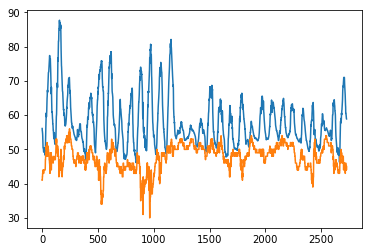

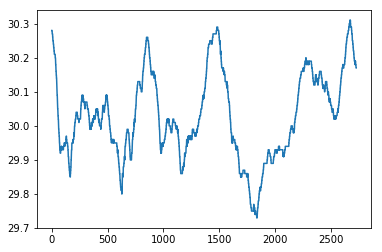

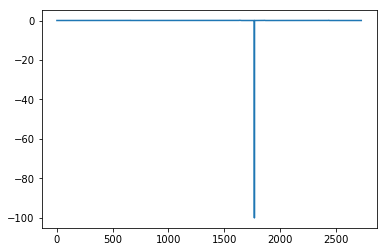

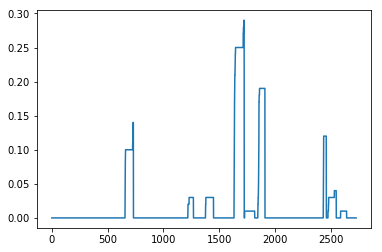

In [18]:
plt.plot(combined_df['TemperatureF']);
plt.plot(combined_df['DewpointF']); plt.show();
plt.plot(combined_df['PressureIn']); plt.show();
plt.plot(combined_df['HourlyPrecipIn']); plt.show();
plt.plot(combined_df['dailyrainin']); plt.show();

In [16]:
station_info = scrape_station_info("WA")

In [24]:
station_info[1:,0]

array(['KWAVENER2', 'KWAMARYS7', 'KWAWALLA2', ..., 'MC9363', 'MCMOW1',
       'MTZILL'], 
      dtype='<U66')

# SCRAPE STATION INFO

In [ ]:
def scrape_station_info(state="WA"):

    """
    A script to scrape the station information published at the following URL:
    https://www.wunderground.com/weatherstation/ListStations.asp?
    selectedState=WA&selectedCountry=United+States&MR=1
    :param state: US State by which to subset WU Station table
    :return: numpy array with station info
    """
    url = "https://www.wunderground.com/" \
          "weatherstation/ListStations.asp?selectedState=" \
          + state + "&selectedCountry=United+States&MR=1"
    raw_site_content = requests.get(url).content
    soup = BeautifulSoup(raw_site_content, 'html.parser')

    list_stations_info = soup.find_all("tr")

    all_station_info = np.array(['id', 'neighborhood', 'city', 'type'])

    for i in range(1, len(list_stations_info)):  # start at 1 to omit headers

        station_info = str(list_stations_info[i]).splitlines()

        # pull out station info
        station_id = station_info[1].split('ID=')[1].split('"')[0]
        station_neighborhood = station_info[2].split('<td>')[1]
        station_neighborhood = station_neighborhood.split('\xa0')[0]
        station_city = station_info[3].split('<td>')[1].split('\xa0')[0]
        station_type = station_info[4].split('station-type">')[1]
        station_type = station_type.split('\xa0')[0]

        station_id = station_id.strip()
        station_neighborhood = station_neighborhood.strip()
        station_city = station_city.strip()
        station_type = station_type.strip()

        all_station_info = np.vstack([all_station_info,
                                      [station_id, station_neighborhood,
                                       station_city, station_type]])

    return all_station_info

In [ ]:
all_info = scrape_station_info()

In [ ]:
all_info[all_info[:,0]=="KWAEDMON15"]

### requests

In [ ]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup

url = "https://www.wunderground.com/weatherstation/ListStations.asp?selectedState=WA&selectedCountry=United+States&MR=1"

raw_site_content = requests.get(url).content
soup = BeautifulSoup(raw_site_content, 'html.parser')

In [ ]:
list_stations_info = soup.find_all("tr")  # one text element in list for each station

all_stations = np.array(['id','neighborhood','city','type'])

for i in range(1, len(list_stations_info)):  # start at 1 to omit first element (col headers)
    
    station_info = str(list_stations_info[i]).splitlines()
    
    # pull out station info
    station_id = station_info[1].split('ID=')[1].split('"')[0].strip()
    station_neighborhood = station_info[2].split('<td>')[1].split('\xa0')[0].strip()
    station_city = station_info[3].split('<td>')[1].split('\xa0')[0].strip()
    station_type = station_info[4].split('station-type">')[1].split('\xa0')[0].strip()

    all_stations = np.vstack([all_stations,[station_id,station_neighborhood,station_city,station_type]])


### urllib3

In [ ]:
import urllib3
http = urllib3.PoolManager()
raw_site_urllib3 = http.request('GET', url)

raw_site_content = raw_site_urllib3.data;

In [ ]:
#for link in soup.find_all('a'):
#    print(link.get('href'))

# SCRAPE OBSERVATION DATA

In [ ]:
start_date = 20160909
end_date = 20160912

In [ ]:
import pandas as pd

start_date = str(start_date)
start_date_yyyy = int(start_date[0:4])
start_date_mm = int(start_date[4:6])
start_date_dd = int(start_date[6:8])

end_date = str(end_date)
end_date_yyyy = int(end_date[0:4])
end_date_mm = int(end_date[4:6])
end_date_dd = int(end_date[6:8])

start_date = pd.datetime(start_date_yyyy, start_date_mm, start_date_dd)
end_date = pd.datetime(end_date_yyyy, end_date_mm, end_date_dd)

date_range = pd.date_range(start_date, end_date)

In [ ]:
day = date_range[0]

In [ ]:
day.year

In [ ]:
import requests
import csv
import os

temp_file_name = 'temp_csv.csv'
url = 'https://www.wunderground.com/weatherstation/WXDailyHistory.asp?ID=KWAEDMON15&day=10&month=9&year=2016&graphspan=day&format=1'
download = requests.get(url)

# with open(temp_file_name, 'w') as temp_file:
#     temp_file.writelines(download.text)

In [ ]:
temp = download.text
type(temp)
temp = temp.replace("\n","")
temp = temp.splitlines()
temp

In [ ]:
import urllib3
from bs4 import BeautifulSoup as Soup

http = urllib3.PoolManager()
r = http.request('GET', url)
r.data

In [ ]:
temp.replace("<br>","")

In [ ]:
# temp = download.text.split('<br>')
# temp = [ line.strip() for line in temp ]
# temp

In [ ]:
def scrape_data(station_id="KWAEDMON15", year=2017, month=4, day=18):

    test_url = "https: // www.wunderground.com / weatherstation / WXDailyHistory.asp?" \
               "ID = KWAEDMON15 & day = 18 & month = 4 & year = 2017 & graphspan = day & format = 1"

    filename = station_id + "_" + str(year) + str(month) + str(day)

    print(filename)

In [ ]:
scrape_data()

In [ ]:
import requests

In [ ]:
station_id="KWAEDMON15"
year=2017
month=4
day=18

print("https://www.wunderground.com/weatherstation/WXDailyHistory.asp?ID={}&day={}&month={}&year={}&graphspan=day&format=1".format(station_id, day, month, year))

In [ ]:
station_id="KWAEDMON15"
year=2017
month=4
day=18

url = "https://www.wunderground.com/weatherstation/WXDailyHistory.asp?ID={}&day={}&month={}&year={}&graphspan=day&format=1".format(station_id, day, month, year)
print(url)